<a href="https://colab.research.google.com/github/MaleeshaThalagala96/First/blob/master/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/HurmetNoka/religion_on_twitter/blob/master/1.Pre-Processing.ipynb

# **TEST DATA** *//Maleesha*

In [ ]:
import matplotlib.pyplot as plt
from math import log, sqrt
import pandas as pd
import numpy as np
import re
import os

# Added
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Gensim
import gensim
from gensim.utils import simple_preprocess

# NLTK
import nltk
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
#Finished

%matplotlib inline

!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize

!pip install wordcloud
from wordcloud import WordCloud


!pip install tweet-preprocessor
import preprocessor as p

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_dir = "../content/drive/"
!ls {data_dir}

ls: cannot access '../content/drive/': No such file or directory


# **Combine all Twitter data for one csv**

In [ ]:
import shutil
shutil.unpack_archive("/content/Two Weeks.zip", "/content/") #first path should be your orginal zip

import os
import glob
import pandas as pd
#set working directory
os.chdir("/content/Two Weeks") #after unzipping your folder

#find all csv files in the folder
#use glob pattern matching -> extension = 'csv'
#save result in list -> all_filenames
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#print(all_filenames)

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

# Preprocessing Part 01

In [ ]:
dataset = pd.read_csv('/content/combined_csv.csv')
#dataset.drop(['Unnamed: 0'], axis = 1, inplace = True)
# dataset['Mood'].value_counts()
dataset = dataset.sample(frac=1)
dataset.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 12 to 23
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Twitter Username  82 non-null     object
 1   id                82 non-null     int64 
 2   user_description  82 non-null     object
 3   location          82 non-null     object
 4   ID                82 non-null     int64 
 5   Text              82 non-null     object
 6   Date/Time         82 non-null     object
 7   Retweet Count     82 non-null     int64 
 8   Favorite Count    82 non-null     int64 
 9   Followers Count   82 non-null     int64 
 10  Friends Count     82 non-null     int64 
dtypes: int64(6), object(5)
memory usage: 7.7+ KB


In [ ]:
dataset.shape

(82, 11)

In [ ]:
data_dir = "../content"
!ls {data_dir}


dataset.csv  @KawdaBoy.csv  sample_data


In [ ]:
# Convert tweets to string
dataset['Text'] = dataset['Text'].apply(str)

#Check for duplicates


In [ ]:
#Check for duplicates
dataset.drop_duplicates(subset=['Text'], keep='first', inplace=True)
dataset.shape

(78, 11)

Count total number of characters and mean length of a tweet

In [ ]:
count = dataset['Text'].str.split().str.len()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)

In [ ]:
print("Total number of words:", count.sum(), "words")


Total number of words: 631 words


In [ ]:
print("Mean number of words per tweet:", round(count.mean(),2), "words") #mean

Mean number of words per tweet: 8.09 words


In [ ]:
dataset["message_length"] = dataset["Text"].str.len()
print("Total length of the dataset is:", dataset.message_length.sum(), "characters")

Total length of the dataset is: 4052 characters


In [ ]:
print("Mean Length of a tweet is:", round(dataset.message_length.mean(),0), "characters")
dataset = dataset.drop(['message_length'], axis=1)

Mean Length of a tweet is: 52.0 characters


Removing Twitter Handles (@user)

In [ ]:
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [ ]:
 dataset['tidy_tweet'] = np.vectorize(remove_users)(dataset['Text'], "@ [\w]*", "@[\w]*")

Normalization

In [ ]:
dataset['tidy_tweet'] = dataset['tidy_tweet'].str.lower()

Hashtag Frequency Table

In [ ]:
dataset['hashtags'] = dataset['tidy_tweet'].apply(lambda twt : re.findall(r"# (\w+)", twt))


In [ ]:
d = Counter(dataset.hashtags.sum())
dataset_hashtags = pd.DataFrame([d]).T

In [ ]:
dataset_hashtags.columns = ['freq']
dataset_hashtags.freq.sum()

0.0

In [ ]:
dataset_hashtags.sort_values(by=['freq'], ascending=False, inplace=True)

In [ ]:
dataset_hashtags.head(20)

,freq


In [ ]:
## Visualization of Top 25 Hashtags
# labels = df_hashtags.head(25).index.values.tolist()
# freq = df_hashtags['freq'].head(25).values.tolist()
# index = np.arange(len(freq))

# print("Among 53.939 Tweets, 15557 Hashtags were used.")
# plt.figure(figsize=(12,9))
# plt.bar(index, freq, alpha=0.8, color= 'black')
# plt.xlabel('Hashtags', fontsize=13)
# plt.ylabel('Frequency', fontsize=13)
# plt.xticks(index, labels, fontsize=11, rotation=90, fontweight="bold") 
# plt.title('Top 25 Hashtags of dataset', fontsize=12, fontweight="bold")
# plt.show()

Remove hashtag coloumn

In [ ]:
# df = df.drop(['hashtags'], axis=1)

Remove Hashtags from tweets

In [ ]:
def remove_hashtags(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [ ]:
dataset['tidy_tweet'] = np.vectorize(remove_hashtags)(dataset['tidy_tweet'], "# [\w]*", "#[\w]*")

Remove Retweets

In [ ]:
def remove_retweets(tweet):
    tweet_no_rt = re.sub(r"\brt", "", tweet)
    return tweet_no_rt

In [ ]:
dataset['tidy_tweet'] = np.vectorize(remove_retweets)(dataset['tidy_tweet'])

In [ ]:
dataset.to_csv('dataset.csv')
print(dataset)

   Twitter Username  ...  hashtags
12         KawdaBoy  ...        []
72         KawdaBoy  ...        []
36         KawdaBoy  ...        []
49         KawdaBoy  ...        []
6          KawdaBoy  ...        []
..              ...  ...       ...
14         KawdaBoy  ...        []
11         KawdaBoy  ...        []
43         KawdaBoy  ...        []
9          KawdaBoy  ...        []
23         KawdaBoy  ...        []

[78 rows x 13 columns]


Remove Links

In [ ]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link


In [ ]:
dataset['tidy_tweet'] = np.vectorize(remove_links)(dataset['tidy_tweet'])

Removing punctuations,Numbers and Special Characters

In [ ]:
dataset['tidy_tweet'] = dataset['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

Remove Short words

In [ ]:
dataset['tidy_tweet'] = dataset['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

Tokenize words and clean-up Punctuations


In [ ]:
def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))  # deacc=True Removes punctuations

In [ ]:
dataset['tidy_tweet_tokens'] = list(tokenize(dataset['tidy_tweet']))

Remove Stopwords

In [ ]:
# Prepare Stop Words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'https', 'twitter','pic','twitt',])

In [ ]:
def remove_stopwords(tweets):
    return [[word for word in simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

In [ ]:
dataset['tokens_no_stop'] = remove_stopwords(dataset['tidy_tweet_tokens'])

Drop rows having less than three tokens

In [ ]:
dataset['length'] = dataset['tokens_no_stop'].apply(len)
dataset = dataset.drop(dataset[dataset['length']<3].index)

In [ ]:
dataset = dataset.drop(['length'], axis=1)
dataset.shape

(21, 15)

In [ ]:
dataset.reset_index(drop=True, inplace=True)

Wordcloud

In [ ]:
# Join the tweet back together
def rejoin_words(row):
    words = row['tokens_no_stop']
    joined_words = (" ".join(words))
    return joined_words

In [ ]:
dataset['no_stop_joined'] = dataset.apply(rejoin_words, axis=1)

In [ ]:
all_words = ' '.join([text for text in dataset['no_stop_joined']])

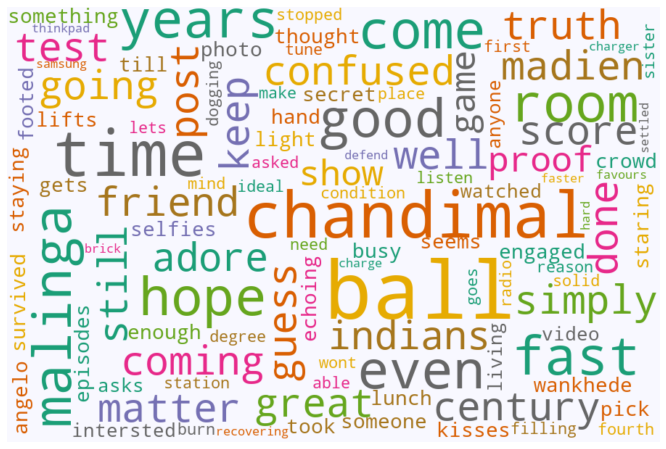

In [ ]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=200,colormap='Dark2').generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Cleaning Effects - Length of tweets

In [ ]:
dataset["message_length"] = dataset["Text"].str.len()
dataset["cleaned_tweet_length"] = dataset["no_stop_joined"].str.len()
dataset_lengths = dataset[['message_length', 'cleaned_tweet_length']]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


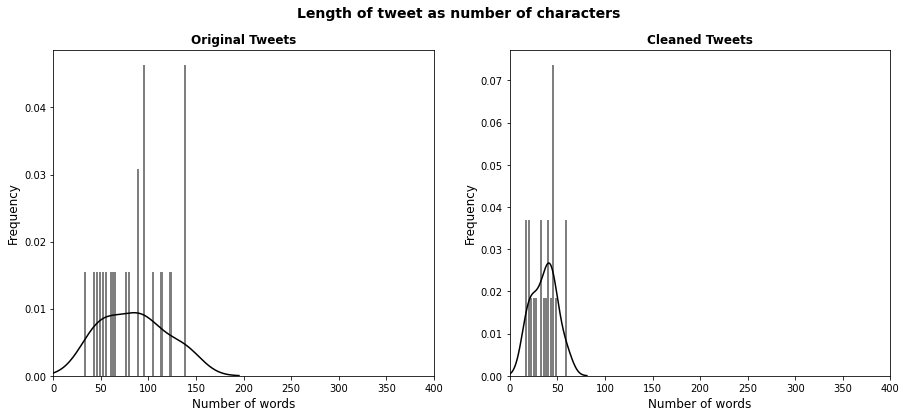

In [ ]:
x1 = dataset_lengths.message_length
x2 = dataset_lengths.cleaned_tweet_length
plt.figure(figsize=(15,6))
plt.suptitle('Length of tweet as number of characters', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)
sns.distplot(x1, color="black", label="No. Words", bins=35, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title("Original Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,400])

# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x2, color="black", label="No. Words", bins=17, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Cleaned Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,400])

plt.show()

Cleaning Effects - Number of Words

In [ ]:
dataset["tweet_words"] = dataset['Text'].str.split().str.len()
dataset["cleaned_tweet_words"] = dataset["no_stop_joined"].str.split().str.len()
dataset_lengths = dataset[['tweet_words', 'cleaned_tweet_words']]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


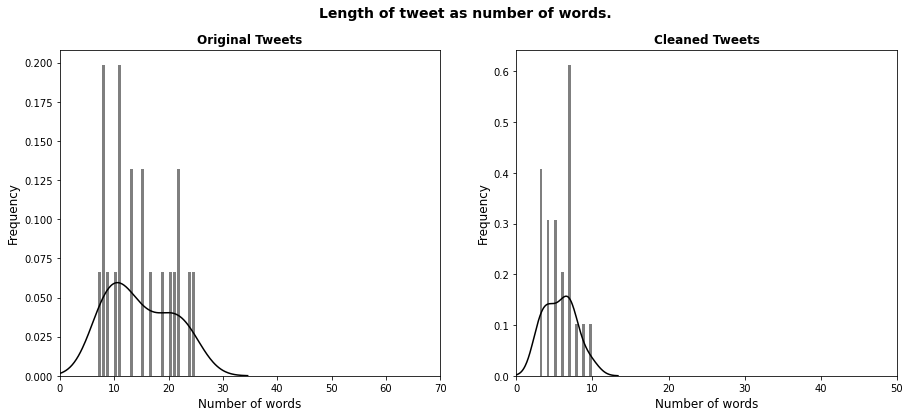

In [ ]:
x_1 = dataset_lengths.tweet_words
x_2 = dataset_lengths.cleaned_tweet_words
plt.figure(figsize=(15,6))
plt.suptitle('Length of tweet as number of words.', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)
sns.distplot(x_1, color="black", label="No. Words", bins=25, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title("Original Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,70])



# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x_2, color="black", label="No. Words", bins=15, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Cleaned Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,50])

plt.show()

In [ ]:
dataset = dataset.drop(['message_length', 'cleaned_tweet_length', 'tweet_words', 'cleaned_tweet_words'], axis=1)

Top 25 Most Frrequent Words

In [ ]:
word_freq = pd.Series(np.concatenate([x.split() for x in dataset.no_stop_joined])).value_counts()

In [ ]:
word_dataset = pd.Series.to_frame(word_freq)
word_dataset['word'] = list(word_dataset.index)
word_dataset.reset_index(drop=True, inplace=True)
word_dataset.columns = ['freq', 'word']

Unique words: 105


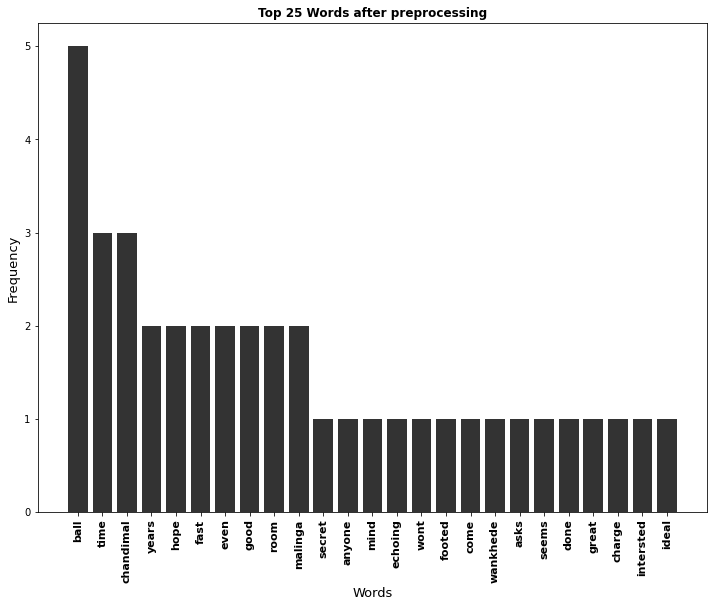

In [ ]:
label = word_dataset['word'].head(25)
freq = word_dataset['freq'].head(25)
index = np.arange(len(freq))

print("Unique words:", len(word_dataset))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 25 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

Username @ Removal in order to merge

In [ ]:
dataset['Twitter Username']
spec_chars = ["@"]
for char in spec_chars:
    dataset['Twitter Username'] = dataset['Twitter Username'].str.replace(char, ' ')
    dataset['Twitter Username'] = dataset['Twitter Username'].str.split().str.join(" ")
dataset['Twitter Username']

0     KawdaBoy
1     KawdaBoy
2     KawdaBoy
3     KawdaBoy
4     KawdaBoy
5     KawdaBoy
6     KawdaBoy
7     KawdaBoy
8     KawdaBoy
9     KawdaBoy
10    KawdaBoy
11    KawdaBoy
12    KawdaBoy
13    KawdaBoy
14    KawdaBoy
15    KawdaBoy
16    KawdaBoy
17    KawdaBoy
18    KawdaBoy
19    KawdaBoy
20    KawdaBoy
Name: Twitter Username, dtype: object

In [ ]:
dataset.to_csv('dataset.csv')
print(dataset)

   Twitter Username  ...                                     no_stop_joined
0          KawdaBoy  ...                                  guess coming ball
1          KawdaBoy  ...                                   years comes test
2          KawdaBoy  ...  years madien century great time score well don...
3          KawdaBoy  ...           still confused matter post friend simply
4          KawdaBoy  ...                  truth indians adore malinga proof
5          KawdaBoy  ...             game show something gets crowd engaged
6          KawdaBoy  ...                  busy thought episodes good enough
7          KawdaBoy  ...                         photo someone took selfies
8          KawdaBoy  ...                        staying light footed secret
9          KawdaBoy  ...  malinga staring lifts hand kisses ball wankhed...
10         KawdaBoy  ...               angelo chandimal survived till lunch
11         KawdaBoy  ...                             seems intersted anyone
12         K

Converting tweets to raw

In [ ]:

# dataset = dataset.groupby('Twitter Username')['no_stop_joined'].apply("','".join).reset_index(name='New Tweet')
dataset = dataset.groupby(['Twitter Username','id','user_description','location','Followers Count','Friends Count'], sort=False).Text.apply("','".join).reset_index(name='New Tweet')
dataset.to_csv('Preprocessed.csv')
print (dataset)


KeyError: ignored

In [ ]:

# csv1 = pandas.read_csv('/content/hhhhhh.csv') # Give your quiz responses csv
# csv2 = pandas.read_csv('/content/Preprocessed.csv') #Give your preprocessed csv
# merged = csv1.merge(csv2, on='Twitter Username')
# merged.to_csv("Final.csv", index=False)

Save to CSV

In [ ]:
# dataset.to_csv('Final.csv')
# print(dataset)